In [14]:
# imports

import asyncio
import json
import os
import matplotlib
import neptune.new as neptune
import nest_asyncio
import numpy as np
import pandas as pd
import re
import time

from collections import defaultdict
from datetime import date
from itertools import product
from matplotlib import pyplot
from poke_env.environment.abstract_battle import AbstractBattle
from poke_env.player.battle_order import ForfeitBattleOrder
from poke_env.player.player import Player
from poke_env.player.random_player import RandomPlayer
from scipy.interpolate import griddata
from src.PlayerQLearning import Player as PlayerQLearning


In [2]:
# global configs

debug = True
save_to_json_file = True
use_validation = True
use_neptune = True

nest_asyncio.apply()
np.random.seed(0)

if use_neptune:
    run = neptune.init(project='leolellisr/rl-pokeenv',
                       api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1NjY1YmJkZi1hYmM5LTQ3M2QtOGU1ZC1iZTFlNWY4NjE1NDQifQ==',
                       name= 'QLearningDeterministic', tags=['Q-Learning', 'Deterministic', 'Train'])


https://app.neptune.ai/leolellisr/rl-pokeenv/e/RLPOK-119
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [3]:
# our team

OUR_TEAM = """
Turtonator @ White Herb  
Ability: Shell Armor  
EVs: 4 Atk / 252 SpA / 252 Spe  
Rash Nature  
- Flamethrower  
- Dragon Pulse  
- Earthquake  
- Shell Smash  

Lapras @ Leftovers  
Ability: Shell Armor  
EVs: 252 HP / 252 SpA / 4 SpD  
Modest Nature  
IVs: 0 Atk  
- Freeze-Dry  
- Surf  
- Thunderbolt  
- Toxic  

Armaldo @ Assault Vest  
Ability: Battle Armor  
EVs: 252 HP / 252 Atk / 4 SpD  
Adamant Nature  
- Earthquake  
- Knock Off  
- X-Scissor  
- Aqua Jet  

Drapion @ Life Orb  
Ability: Battle Armor  
EVs: 252 Atk / 4 SpD / 252 Spe  
Jolly Nature  
- Poison Jab  
- Knock Off  
- Earthquake  
- X-Scissor  

Kabutops @ Aguav Berry  
Ability: Battle Armor  
EVs: 252 Atk / 4 SpD / 252 Spe  
Jolly Nature  
- Liquidation  
- Leech Life  
- Knock Off  
- Swords Dance  

Falinks @ Iapapa Berry  
Ability: Battle Armor  
EVs: 252 HP / 252 Atk / 4 SpD  
Adamant Nature  
- Close Combat  
- Poison Jab  
- Iron Head  
- No Retreat  
"""


In [4]:
# opponent's team

OP_TEAM = """
Cloyster @ Assault Vest  
Ability: Shell Armor  
EVs: 248 HP / 252 Atk / 8 SpA  
Naughty Nature  
- Icicle Spear  
- Surf  
- Tri Attack  
- Poison Jab  

Omastar @ White Herb  
Ability: Shell Armor  
EVs: 252 SpA / 4 SpD / 252 Spe  
Modest Nature  
IVs: 0 Atk  
- Surf  
- Ancient Power  
- Earth Power  
- Shell Smash  

Crustle @ Leftovers  
Ability: Shell Armor  
EVs: 252 HP / 252 Atk / 4 SpD  
Adamant Nature  
- Earthquake  
- Knock Off  
- X-Scissor  
- Stealth Rock  

Escavalier @ Life Orb  
Ability: Shell Armor  
EVs: 248 HP / 252 Atk / 8 SpD  
Adamant Nature  
- Knock Off  
- Swords Dance  
- Iron Head  
- Poison Jab  

Drednaw @ Aguav Berry  
Ability: Shell Armor  
EVs: 248 HP / 252 Atk / 8 SpD  
Adamant Nature  
- Liquidation  
- Earthquake  
- Poison Jab  
- Swords Dance  

Type: Null @ Eviolite  
Ability: Battle Armor  
EVs: 252 HP / 252 Atk / 4 SpD  
Adamant Nature  
- Facade  
- Sleep Talk  
- Shadow Claw  
- Rest  

"""


In [5]:
N_OUR_MOVE_ACTIONS = 4
N_OUR_SWITCH_ACTIONS = 5
N_OUR_ACTIONS = N_OUR_MOVE_ACTIONS + N_OUR_SWITCH_ACTIONS

ALL_OUR_ACTIONS = np.array(range(0, N_OUR_ACTIONS))

NAME_TO_ID_DICT = {
    "turtonator": 0,
    "lapras": 1,
    "armaldo": 2,
    "drapion": 3,
    "kabutops": 4,
    "falinks": 5,
    "cloyster": 6,
    "omastar": 7,
    "crustle": 8,
    "escavalier": 9,
    "drednaw": 10,
    "typenull": 11
}


In [6]:
# Max-damage player

class MaxDamagePlayer(Player):
    def choose_move(self, battle):
        if battle.available_moves:
            best_move = max(battle.available_moves, key=lambda move: move.base_power)
            return self.create_order(best_move)
        else:
            return self.choose_random_move(battle)


In [7]:
# Q-learning player

class QLearningPlayer(PlayerQLearning):
    def __init__(self, battle_format, team, n0, gamma):
        super().__init__(battle_format=battle_format, team=team)
        self.N = defaultdict(lambda: np.zeros(N_OUR_ACTIONS))
        self.Q = defaultdict(lambda: np.zeros(N_OUR_ACTIONS))
        self.n0 = n0
        self.gamma = gamma
        self.state = None
        self.action = None

    def choose_move(self, battle):
        if self.state is not None:
            # observe R, S'
            reward = self.compute_reward(battle)
            next_state = self.embed_battle(battle)
            # Q-learning
            self.N[self.state][self.action] += 1
            alpha = 1.0 / self.N[self.state][self.action]
            self.Q[self.state][self.action] += \
                alpha * (reward + self.gamma * np.max(self.Q[next_state]) - self.Q[self.state][self.action])
            # S <- S'
            self.state = next_state
        else:
            # S first initialization
            self.state = self.embed_battle(battle)
            
        # Choose A from S using epsilon-greedy policy
        self.action = self.pi(self.state)

        # if the selected action is not possible, perform a random move instead
        if self.action == -1:
            return ForfeitBattleOrder()
        elif self.action < 4 and self.action < len(battle.available_moves) and not battle.force_switch:
            return self.create_order(battle.available_moves[self.action])
        elif 0 <= self.action - 4 < len(battle.available_switches):
            return self.create_order(battle.available_switches[self.action - 4])
        else:
            return self.choose_random_move(battle)

    def _battle_finished_callback(self, battle):
        if use_neptune:
            run[f'N0: {self.n0} gamma: {self.gamma} win_acc'].log(self.n_won_battles / len(self._reward_buffer))

    ''' Helper functions '''

    # epsilon-greedy policy
    def pi(self, state):
        epsilon = self.n0 / (self.n0 + np.sum(self.N[state]))
        # let's get the greedy action. Ties must be broken arbitrarily
        greedy_action = np.random.choice(np.where(self.Q[state] == self.Q[state].max())[0])
        action_pick_probability = np.full(N_OUR_ACTIONS, epsilon / N_OUR_ACTIONS)
        action_pick_probability[greedy_action] += 1 - epsilon
        return np.random.choice(ALL_OUR_ACTIONS, p=action_pick_probability)

    # the embed battle is our state
    # 12 factors: our active mon, opponent's active mon, 4 moves base power, 4 moves multipliers, num fainted mons
    @staticmethod
    def embed_battle(battle):
        # -1 indicates that the move does not have a base power
        # or is not available
        moves_base_power = -np.ones(4)
        moves_dmg_multiplier = np.ones(4)
        for i, move in enumerate(battle.available_moves):
            moves_base_power[i] = (
                    move.base_power / 100
            )  # Simple rescaling to facilitate learning
            if move.type:
                moves_dmg_multiplier[i] = move.type.damage_multiplier(
                    battle.opponent_active_pokemon.type_1,
                    battle.opponent_active_pokemon.type_2,
                )

        # We count how many pokemons have fainted in each team
        n_fainted_mon_team = (
            len([mon for mon in battle.team.values() if mon.fainted])
        )
        n_fainted_mon_opponent = (
            len([mon for mon in battle.opponent_team.values() if mon.fainted])
        )

        state = list()
        state.append(NAME_TO_ID_DICT[str(battle.active_pokemon).split(' ')[0]])
        state.append(NAME_TO_ID_DICT[str(battle.opponent_active_pokemon).split(' ')[0]])
        for move_base_power in moves_base_power:
            state.append('{0:.2f}'.format(move_base_power))
        for move_dmg_multiplier in moves_dmg_multiplier:
            state.append('{0:.2f}'.format(move_dmg_multiplier))
        state.append(n_fainted_mon_team)
        state.append(n_fainted_mon_opponent)

        return str(state)

    # Computing rewards
    def reward_computing_helper(
            self,
            battle: AbstractBattle,
            *,
            fainted_value: float = 0.15,
            hp_value: float = 0.15,
            number_of_pokemons: int = 6,
            starting_value: float = 0.0,
            status_value: float = 0.15,
            victory_value: float = 1.0
    ) -> float:
        # 1st compute
        if battle not in self._reward_buffer:
            self._reward_buffer[battle] = starting_value
        current_value = 0

        # Verify if pokemon have fainted or have status
        for mon in battle.team.values():
            current_value += mon.current_hp_fraction * hp_value
            if mon.fainted:
                current_value -= fainted_value
            elif mon.status is not None:
                current_value -= status_value

        current_value += (number_of_pokemons - len(battle.team)) * hp_value

        # Verify if opponent pokemon have fainted or have status
        for mon in battle.opponent_team.values():
            current_value -= mon.current_hp_fraction * hp_value
            if mon.fainted:
                current_value += fainted_value
            elif mon.status is not None:
                current_value += status_value

        current_value -= (number_of_pokemons - len(battle.opponent_team)) * hp_value

        # Verify if we won or lost
        if battle.won:
            current_value += victory_value
        elif battle.lost:
            current_value -= victory_value

        # Value to return
        to_return = current_value - self._reward_buffer[battle]
        self._reward_buffer[battle] = current_value
        if use_neptune:
            run[f'N0: {self.n0} gamma: {self.gamma} reward_buffer'].log(current_value)
        return to_return

    # Calling reward_computing_helper
    def compute_reward(self, battle) -> float:
        return self.reward_computing_helper(battle, fainted_value=2, hp_value=1, victory_value=15)


In [8]:
# validation player

class ValidationPlayer(PlayerQLearning):
    def __init__(self, battle_format, team, q):
        super().__init__(battle_format=battle_format, team=team)
        self.Q = q

    def choose_move(self, battle):
        state = self.embed_battle(battle)
        # let's get the greedy action. Ties must be broken arbitrarily
        if state in self.Q.keys():
            action = np.random.choice(np.where(self.Q[state] == self.Q[state].max())[0])
        else:
            return self.choose_random_move(battle)

        # if the selected action is not possible, perform a random move instead
        if action == -1:
            return ForfeitBattleOrder()
        elif action < 4 and action < len(battle.available_moves) and not battle.force_switch:
            return self.create_order(battle.available_moves[action])
        elif 0 <= action - 4 < len(battle.available_switches):
            return self.create_order(battle.available_switches[action - 4])
        else:
            return self.choose_random_move(battle)

    def _battle_finished_callback(self, battle):
        pass

    # the embed battle is our state
    # 12 factors: our active mon, opponent's active mon, 4 moves base power, 4 moves multipliers, num fainted mons
    @staticmethod
    def embed_battle(battle):
        # -1 indicates that the move does not have a base power
        # or is not available
        moves_base_power = -np.ones(4)
        moves_dmg_multiplier = np.ones(4)
        for i, move in enumerate(battle.available_moves):
            moves_base_power[i] = (
                    move.base_power / 100
            )  # Simple rescaling to facilitate learning
            if move.type:
                moves_dmg_multiplier[i] = move.type.damage_multiplier(
                    battle.opponent_active_pokemon.type_1,
                    battle.opponent_active_pokemon.type_2,
                )

        # We count how many pokemons have fainted in each team
        n_fainted_mon_team = (
            len([mon for mon in battle.team.values() if mon.fainted])
        )
        n_fainted_mon_opponent = (
            len([mon for mon in battle.opponent_team.values() if mon.fainted])
        )

        state = list()
        state.append(NAME_TO_ID_DICT[str(battle.active_pokemon).split(' ')[0]])
        state.append(NAME_TO_ID_DICT[str(battle.opponent_active_pokemon).split(' ')[0]])
        for move_base_power in moves_base_power:
            state.append('{0:.2f}'.format(move_base_power))
        for move_dmg_multiplier in moves_dmg_multiplier:
            state.append('{0:.2f}'.format(move_dmg_multiplier))
        state.append(n_fainted_mon_team)
        state.append(n_fainted_mon_opponent)

        return str(state)


In [9]:
# global parameters

# possible values for num_battles (number of episodes)
n_battles_array = [10000]
# exploration schedule from MC, i. e., epsilon(t) = N0 / (N0 + N(S(t)))
n0_array = [0.0001, 0.001, 0.01]
# possible values for gamma (discount factor)
gamma_array = [0.75]

list_of_params = [
    {
        'n_battles': n_battles,
        'n0': n0,
        'gamma': gamma
    } for n_battles, n0, gamma in product(n_battles_array, n0_array, gamma_array)
]


In [10]:
# json helper functions

def save_dict_to_json(path_dir, filename, data, append=True):
    if not os.path.exists(path_dir):
        os.makedirs(path_dir)
    full_filename = path_dir + "/" + filename
    if os.path.exists(full_filename) and append:
        with open(full_filename, "r") as file:
            value_dict = json.load(file)
            for key in data:
                value_dict[key] = data[key] if isinstance(data[key], list) else data[key].tolist()
            file.close()
    else:
        value_dict = dict()
        for key in data:
            value_dict[key] = data[key] if isinstance(data[key], list) else data[key].tolist()
    # write
    with open(full_filename, "w") as file:
        json.dump(value_dict, file)
        file.close()


def read_dict_from_json(path_dir, filename):
    full_filename = path_dir + "/" + filename
    if not os.path.exists(full_filename):
        return dict()
    file = open(full_filename, "r")
    data = json.load(file)
    file.close()
    return data


In [11]:
# main (let's battle!)

# training
async def do_battle_training():
    for params in list_of_params:
        start = time.time()
        if use_neptune:
            run['params'] = params
        params['player'] = QLearningPlayer(battle_format="gen8ou", team=OUR_TEAM, n0=params['n0'], gamma=params['gamma'])
        params['opponent'] = MaxDamagePlayer(battle_format="gen8ou", team=OP_TEAM)
        await params['player'].battle_against(opponent=params['opponent'], n_battles=params['n_battles'])
        if debug:
            print("training: num battles (episodes)=%d, N0=%.4f, gamma=%.2f, wins=%d, winning %%=%.2f, total time=%s sec" %
                  (
                      params['n_battles'],
                      round(params['n0'], 4),
                      round(params['gamma'], 2),
                      params['player'].n_won_battles,
                      round((params['player'].n_won_battles / params['n_battles']) * 100, 2),
                      round(time.time() - start, 2)
                  ))

        # save Q to json file
        if save_to_json_file:
            today_s = str(date.today())
            n_battle_s = str(params['n_battles'])
            n0_s = str(round(params['n0'], 4))
            gamma_s = str(round(params['gamma'], 2))
            winning_percentage_s = str(round((params['player'].n_won_battles / params['n_battles']) * 100, 2))
            filename = "Q_" + today_s + "_" + n_battle_s + "_" + n0_s + "_" + gamma_s + "_" + winning_percentage_s + ".json"
            save_dict_to_json("./Q_Learning_table", filename, params['player'].Q, False)

        # statistics: key: "n_battles, n0, gamma", values: list of win or lose
        #key = str(params['n_battles']) + "_" + str(round(params['n0'], 4)) + "_" + str(round(params['gamma'], 2))
        #winning_status = list()
        #for battle in params['player']._battles.values():
        #    if battle.won:
        #        winning_status.append(True)
        #    else:
        #        winning_status.append(False)
        # save statistics json file (append)
        #data = dict()
        #data[key] = winning_status
        #save_dict_to_json("./Q_Learning_statistics", "statistics.json", data)
    if use_neptune:
        run.stop()


loop = asyncio.get_event_loop()
loop.run_until_complete(loop.create_task(do_battle_training()))


training: num battles (episodes)=10000, N0=0.0001, gamma=0.75, wins=4154, winning %=41.54, total time=1684.17 sec
training: num battles (episodes)=10000, N0=0.0010, gamma=0.75, wins=3086, winning %=30.86, total time=2349.35 sec


2021-11-05 17:46:11,286 - QLearningPlayer 1 - WARNING - Trying to login as QLearningPlayer 1, showdown returned  QLearningPlayer 1@! - this might prevent future actions from this agent. Changing the agent's username might solve this problem.
2021-11-05 17:46:11,410 - MaxDamagePlayer 1 - WARNING - Trying to login as MaxDamagePlayer 1, showdown returned  MaxDamagePlayer 1@! - this might prevent future actions from this agent. Changing the agent's username might solve this problem.


training: num battles (episodes)=10000, N0=0.0100, gamma=0.75, wins=3767, winning %=37.67, total time=1966.15 sec
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 38 operations to synchronize with Neptune. Do not kill this process.


All 38 operations synced, thanks for waiting!


In [ ]:
# plotting helper functions

def plot_2d(path, title, x_label, x_array, y_label, y_array):
    # print("plotting %s" % title)
    # set labels and plot surface
    figure = matplotlib.pyplot.figure(figsize=(20, 10))
    ax = figure.gca()
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.plot(x_array, y_array)
    # pyplot.show()
    if not os.path.exists(path):
        os.makedirs(path)
    filename = path + "/" + title + "_" + x_label + "_" + y_label + "_" + ".pdf"
    figure.savefig(filename, dpi=figure.dpi)
    pyplot.close(figure)
    # print("done!")


def plot_3d(path, title, x_label, x_array, y_label, y_array, z_label, z_array):
    # print("plotting %s" % title)
    xyz = {'x': x_array, 'y': y_array, 'z': z_array}
    df = pd.DataFrame(xyz, index=range(len(xyz['x'])))
    xv, yv = np.meshgrid(x_array, y_array)
    zv = griddata((df['x'], df['y']), df['z'], (xv, yv), method='nearest')
    # set labels and plot surface
    figure = matplotlib.pyplot.figure(figsize=(20, 10))
    ax = figure.gca(projection='3d')
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    surface = ax.plot_surface(xv, yv, zv, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, linewidth=0,
                              antialiased=False)
    figure.colorbar(surface)
    # pyplot.show()
    if not os.path.exists(path):
        os.makedirs(path)
    filename = path + "/" + title + ".pdf"
    figure.savefig(filename, dpi=figure.dpi)
    pyplot.close(figure)
    # print("done!")


In [ ]:
# plot value from state-action pair

# def plot_v_from_state_action_json(path_dir, x_label, x_func, y_label, y_func):
#     # open files
#     for filename in os.listdir(path_dir):
#         q = dict()
#         q_json = read_dict_from_json(path_dir, filename)
#         for key in q_json.keys():
#             q[key] = np.array(q_json[key])
#         x_values = []
#         y_values = []
#         z_values = []
#         # for state, actions
#         for state, actions in q.items():
#             state = re.sub(r"[,!?><:'\[\]()@*~#]", "", state)
#             key_float = [float(k) for k in state.split()]
#             x_emb = x_func(key_float)
#             x_values.append(x_emb)
#             y_emb = y_func(key_float)
#             y_values.append(y_emb)
#             action_value = np.max(actions)
#             z_values.append(action_value)
#         # plot 3D
#         title = "v_from_" + filename
#         plot_3d("./Q_Learning_plot", title, x_label, x_values, y_label, y_values, "V", z_values)


# # plots from Q
# plot_v_from_state_action_json(path_dir="./Q_Learning_table",
#                               x_label="20 * index_pokemon + sum(moves_base_power * moves_dmg_multiplier)",
#                               x_func=lambda k: 20 * k[0] + k[1] * k[5] + k[2] * k[6] + k[3] * k[7] + k[4] * k[8],
#                               y_label="remaining_mon_team - remaining_mon_opponent",
#                               y_func=lambda k: k[8] - k[9])


In [ ]:
# plot additional statistics

def plot_statistics_json(path_dir, filename="statistics.json"):
    statistics = read_dict_from_json(path_dir, filename)
    # win/lost vs. episode number
    for key in statistics.keys():
        key_elements = key.split("_")
        n_battles = key_elements[0]
        n0 = key_elements[1]
        gamma = key_elements[2]
        value = statistics[key]
        plot_2d(path="./Q_Learning_plot",
                title="acc_victories_n_battles_" + n_battles + "_N0_" + n0 + "_gamma_" + gamma,
                x_label="episodes",
                x_array=np.array(range(0, len(value))),
                y_label="acc victories",
                y_array=np.cumsum(value).astype(np.int))

    # winning % by set of parameters
    n_battles = ""
    x_values = []
    y_values = []
    z_values = []
    for key in statistics.keys():
        key_elements = key.split("_")
        n_battles = key_elements[0]
        n0 = key_elements[1]
        gamma = key_elements[2]
        value = statistics[key]
        x_values.append(n0)
        y_values.append(gamma)
        z_values.append(value.count(True) / len(value))
    plot_3d(path="./Q_Learning_plot",
            title="winning_percentage_n_battles_" + n_battles,
            x_label="N0",
            x_array=np.array(x_values).astype(np.float),
            y_label="gamma",
            y_array=np.array(y_values).astype(np.float),
            z_label="winning %",
            z_array=np.array(z_values))


# plots from statistics
plot_statistics_json("./Q_Learning_statistics")


winning % by set of parameters for 1500 battles


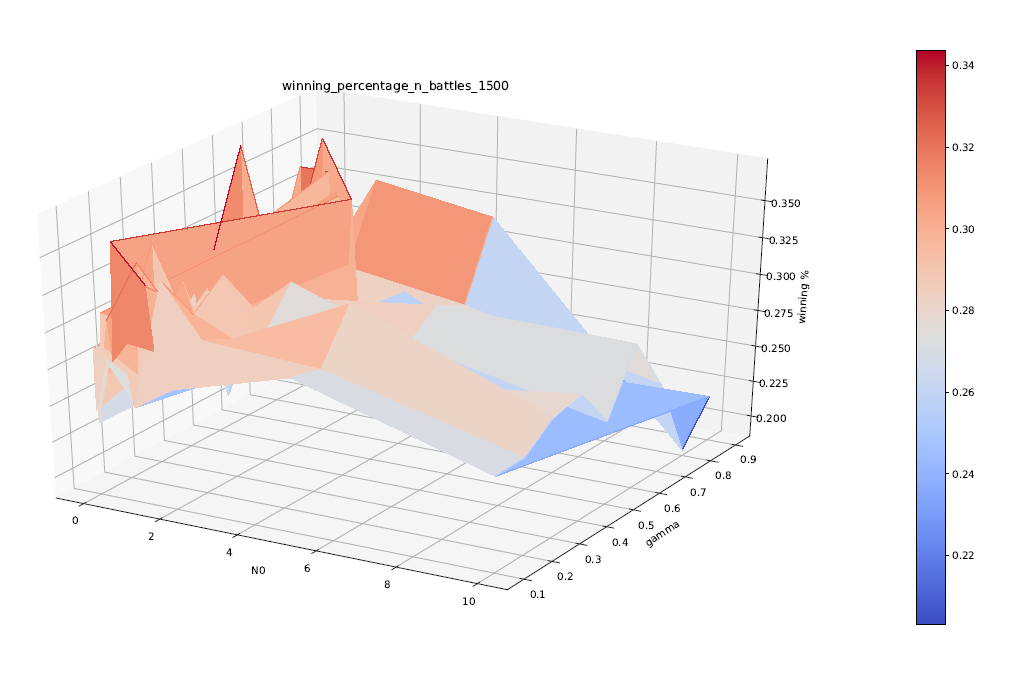

In [12]:
# validation

async def do_battle_validation(path_dir):
    # read from json
    for filename in os.listdir(path_dir):
        # Q-learned table
        q = defaultdict()
        q_json = read_dict_from_json(path_dir, filename)
        for key in q_json.keys():
            q[key] = np.array(q_json[key])
        # params: n_battles, n0, gamma
        params = filename.split("_")
        n_battles = int(params[2])
        n0 = float(params[3])
        gamma = float(params[4])

        # validation (play 1/3 of the battles using Q-learned table)
        start = time.time()
        validation_player = ValidationPlayer(battle_format="gen8ou", team=OUR_TEAM, q=q)
        opponent = MaxDamagePlayer(battle_format="gen8ou", team=OP_TEAM)
        n_battles_validation = int(n_battles / 3)
        await validation_player.battle_against(opponent=opponent, n_battles=n_battles_validation)
        print("validation: num battles (episodes)=%d, N0=%.4f, gamma=%.2f, wins=%d, winning %%=%.2f, total time=%s sec" %
              (
                  n_battles_validation,
                  n0,
                  gamma,
                  validation_player.n_won_battles,
                  round((validation_player.n_won_battles / n_battles_validation) * 100, 2),
                  round(time.time() - start, 2)
              ))


if use_validation:
    loop = asyncio.get_event_loop()
    loop.run_until_complete(loop.create_task(do_battle_validation("./Q_Learning_table")))


validation: num battles (episodes)=3333, N0=0.0001, gamma=0.75, wins=1446, winning %=43.38, total time=572.78 sec
validation: num battles (episodes)=3333, N0=0.0010, gamma=0.75, wins=1077, winning %=32.31, total time=444.55 sec
validation: num battles (episodes)=3333, N0=0.0100, gamma=0.75, wins=1461, winning %=43.83, total time=582.1 sec


2021-11-05 18:46:11,258 - MaxDamagePlayer 2 - WARNING - Trying to login as MaxDamagePlayer 2, showdown returned  MaxDamagePlayer 2@! - this might prevent future actions from this agent. Changing the agent's username might solve this problem.--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\leolellisr\anaconda3\envs\poke_env\lib\logging\__init__.py", line 996, in emit
    stream.write(msg)
  File "C:\Users\leolellisr\anaconda3\envs\poke_env\lib\site-packages\neptune\new\internal\streams\std_stream_capture_logger.py", line 41, in write
    self._logger.log(data)
  File "C:\Users\leolellisr\anaconda3\envs\poke_env\lib\site-packages\neptune\new\logging\logger.py", line 27, in log
    self._run[self._attribute_name].log(msg)
  File "C:\Users\leolellisr\anaconda3\envs\poke_env\lib\site-packages\neptune\new\run.py", line 67, in inner_fun
    raise InactiveRunException(short_id=self._short_id)
neptune.new.exceptions.InactiveRunException: 

----InactiveRunException------

In [16]:
# validation

async def do_battle_validation(path_dir):
    # read from json
    for filename in os.listdir(path_dir):
        # Q-learned table
        q = defaultdict()
        q_json = read_dict_from_json(path_dir, filename)
        for key in q_json.keys():
            q[key] = np.array(q_json[key])
        # params: n_battles, n0, gamma
        params = filename.split("_")
        n_battles = int(params[2])
        n0 = float(params[3])
        gamma = float(params[4])

        # validation (play 1/3 of the battles using Q-learned table)
        start = time.time()
        validation_player = ValidationPlayer(battle_format="gen8ou", team=OUR_TEAM, q=q)
        opponent = RandomPlayer(battle_format="gen8ou", team=OP_TEAM)
        n_battles_validation = int(n_battles / 3)
        await validation_player.battle_against(opponent=opponent, n_battles=n_battles_validation)
        print("validation: num battles (episodes)=%d, N0=%.4f, gamma=%.2f, wins=%d, winning %%=%.2f, total time=%s sec" %
              (
                  n_battles_validation,
                  n0,
                  gamma,
                  validation_player.n_won_battles,
                  round((validation_player.n_won_battles / n_battles_validation) * 100, 2),
                  round(time.time() - start, 2)
              ))


if use_validation:
    loop = asyncio.get_event_loop()
    loop.run_until_complete(loop.create_task(do_battle_validation("./Q_Learning_table")))

validation: num battles (episodes)=3333, N0=0.0001, gamma=0.75, wins=2801, winning %=84.04, total time=698.99 sec


2021-11-05 19:47:58,787 - ValidationPlayer 2 - WARNING - Trying to login as ValidationPlayer 2, showdown returned  ValidationPlayer 2@! - this might prevent future actions from this agent. Changing the agent's username might solve this problem.
2021-11-05 19:47:58,821 - ValidationPlayer 1 - WARNING - Trying to login as ValidationPlayer 1, showdown returned  ValidationPlayer 1@! - this might prevent future actions from this agent. Changing the agent's username might solve this problem.
2021-11-05 19:47:58,824 - MaxDamagePlayer 5 - WARNING - Trying to login as MaxDamagePlayer 5, showdown returned  MaxDamagePlayer 5@! - this might prevent future actions from this agent. Changing the agent's username might solve this problem.
2021-11-05 19:47:58,907 - ValidationPlayer 3 - WARNING - Trying to login as ValidationPlayer 3, showdown returned  ValidationPlayer 3@! - this might prevent future actions from this agent. Changing the agent's username might solve this problem.
2021-11-05 19:47:58,915

validation: num battles (episodes)=3333, N0=0.0010, gamma=0.75, wins=2800, winning %=84.01, total time=794.75 sec
validation: num battles (episodes)=3333, N0=0.0100, gamma=0.75, wins=2934, winning %=88.03, total time=601.89 sec


In [17]:
import os
import json
import re
from datetime import date
today = date.today()


In [18]:
from matplotlib import pyplot as plt


In [19]:
output_folder = "images/vfunction"

In [20]:
v_array = []
directoryQ = r'S:\poke_env\Q_Learning_table'

for filenameQ in os.listdir(directoryQ):
    Qjson_file = open(directoryQ+'/'+filenameQ,)
    Qjson = json.load(Qjson_file)

    for key in Qjson:
        Qjson[key] = np.array(Qjson[key])
        
    z_values = []
    x_values = []
    y_values = []
    #for state, actions in test['player_val'].Q.items():
    for state, actions in Qjson.items():    
        action_value = np.max(actions)
        z_values.append(action_value)
        state = re.sub(r"[,!?><:'\[\]()@*~#]","", state)
        key_float = [float(k) for k in state.split()]
        x_emb = key_float[0]*20+key_float[1]*key_float[5]+key_float[2]*key_float[6]+key_float[3]*key_float[7]+key_float[4]*key_float[8]
        x_values.append(x_emb)
        y_emb = key_float[8]-key_float[9]
        y_values.append(y_emb)
        #V[x_emb,y_emb] = action_value
    v_array.append((x_values, y_values, z_values))

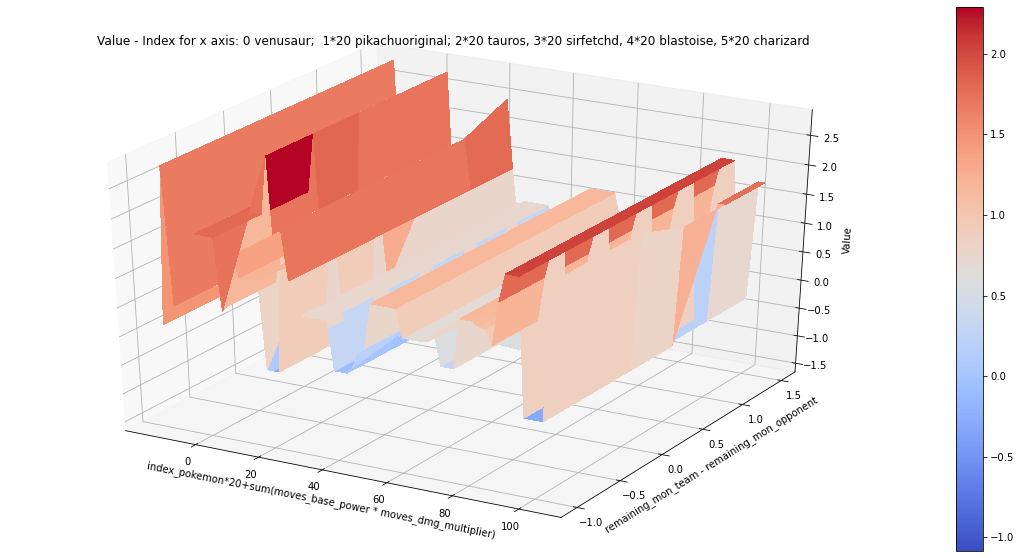

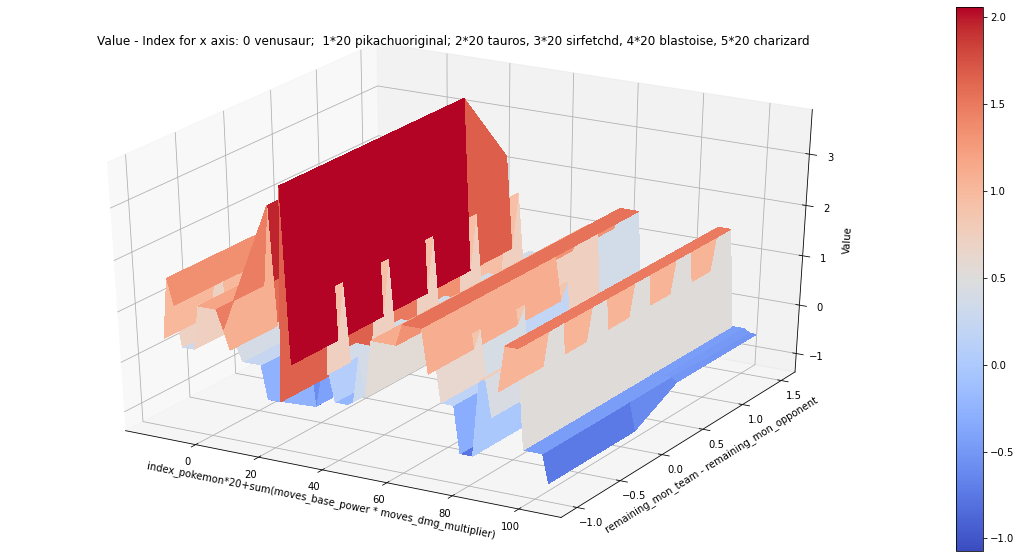

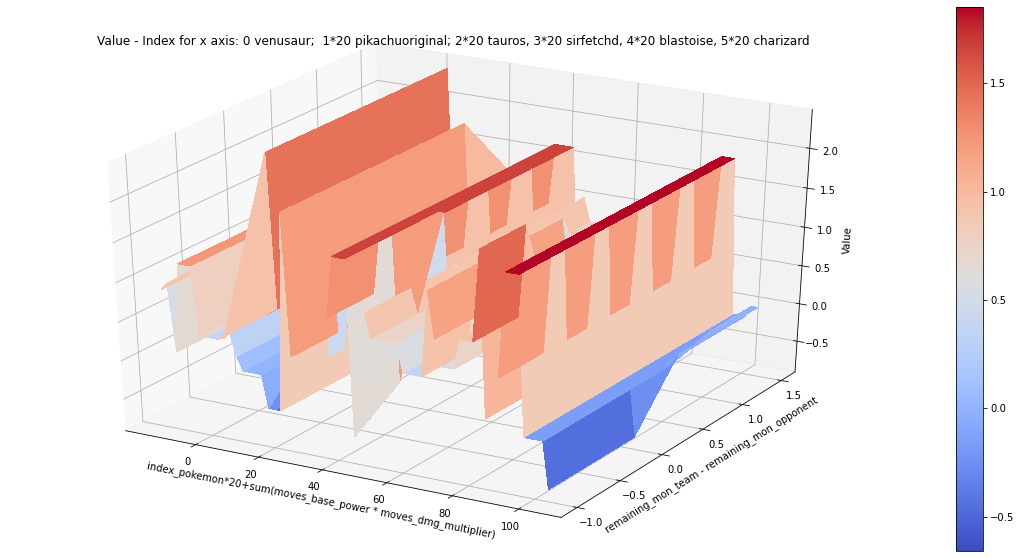

In [21]:
import pandas as pd
from scipy.interpolate import griddata
# create 1D-arrays from the 2D-arrays
for vvalue, filenameQ in zip(v_array, os.listdir(directoryQ)):
    filenameQ = re.sub(r"[,.!?><:'\[\]()@*~#]","_", filenameQ)
    x_values, y_values, z_values = vvalue 
    z_plot = np.array(z_values).reshape(len(z_values),1)
    x_plot = np.array(x_values)
    y_plot = np.array(y_values)
    xyz = {'x': x_plot, 'y': y_plot, 'z': np.array(z_values)}
    df = pd.DataFrame(xyz, index=range(len(xyz['x']))) 
    x1 = np.linspace(df['x'].min(), df['x'].max(), len(df['x'].unique()))
    y1 = np.linspace(df['y'].min(), df['y'].max(), len(df['y'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    z2 = griddata((df['x'], df['y']), df['z'], (x2, y2), method='nearest')

    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca(projection='3d')
    ax.set_xlabel('index_pokemon*20+sum(moves_base_power * moves_dmg_multiplier)')
    ax.set_ylabel('remaining_mon_team - remaining_mon_opponent')
    ax.set_zlabel('Value')
    ax.set_title('Value - Index for x axis: 0 venusaur;  1*20 pikachuoriginal; 2*20 tauros, 3*20 sirfetchd, 4*20 blastoise, 5*20 charizard')

    surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm,
        linewidth=0, antialiased=False)
    fig.colorbar(surf)
    filename = filenameQ+'_Det_Index.pdf'
    path_plot = output_folder+'/QLearning/'
    if not os.path.exists(path_plot):
        os.makedirs(path_plot)
    plt.savefig(path_plot+filename) 
    plt.show()

In [22]:
# x: sum(moves_base_power * moves_dmg_multiplier)
# y: remaining_mon_team - remaining_mon_opponent
# z: value function

v_array = []
directoryQ = r'S:\poke_env\Q_Learning_table'

for filenameQ in os.listdir(directoryQ):
    Qjson_file = open(directoryQ+'/'+filenameQ,)
    Qjson = json.load(Qjson_file)

    for key in Qjson:
        Qjson[key] = np.array(Qjson[key])
        
    z_values = []
    x_values = []
    y_values = []

    for state, actions in Qjson.items():    
        action_value = np.max(actions)
        z_values.append(action_value)
        state = re.sub(r"[,!?><:'\[\]()@*~#]","", state)
        key_float = [float(k) for k in state.split()]
        x_emb = key_float[1]*key_float[5]+key_float[2]*key_float[6]+key_float[3]*key_float[7]+key_float[4]*key_float[8]
        x_values.append(x_emb)
        y_emb = key_float[8]-key_float[9]
        y_values.append(y_emb)
        #V[x_emb,y_emb] = action_value
    v_array.append((x_values, y_values, z_values))

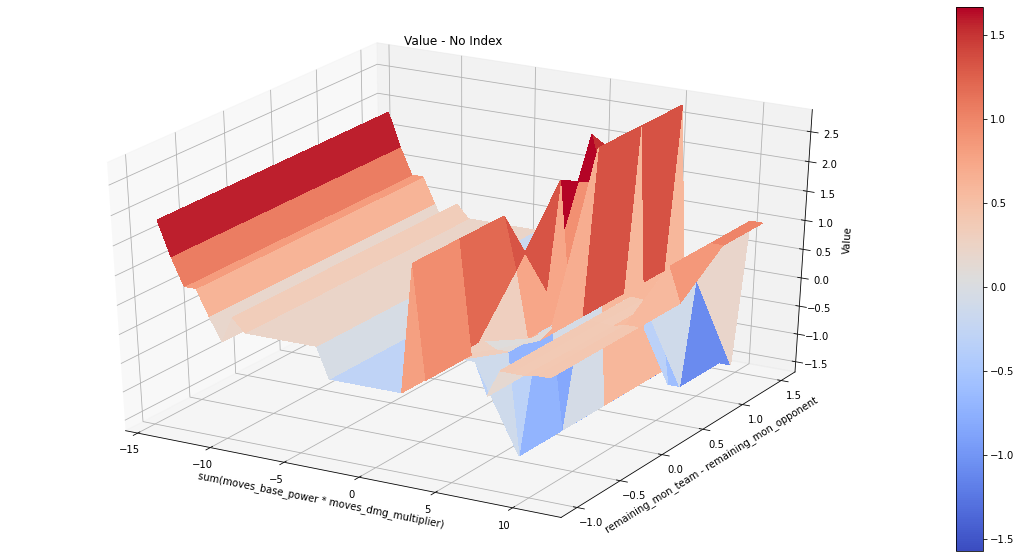

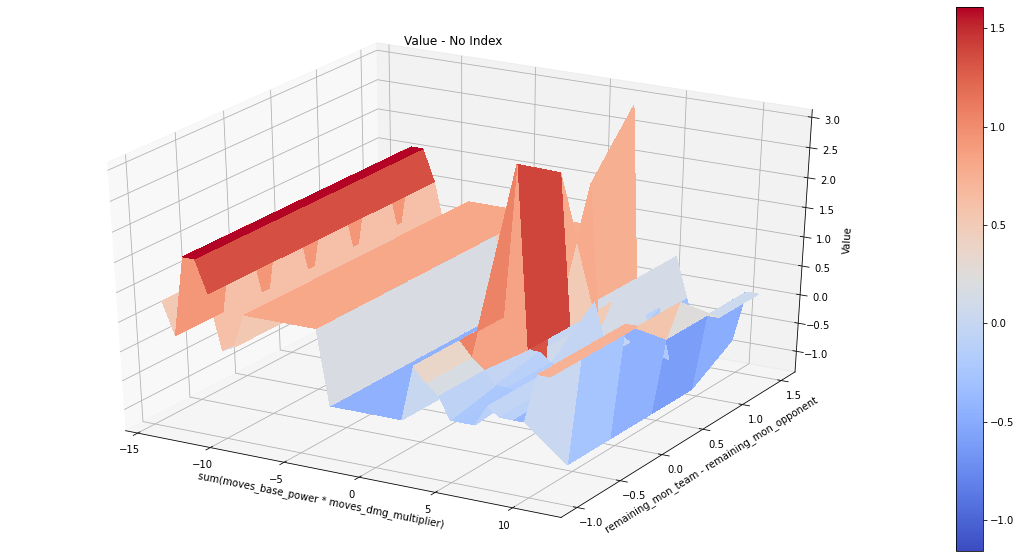

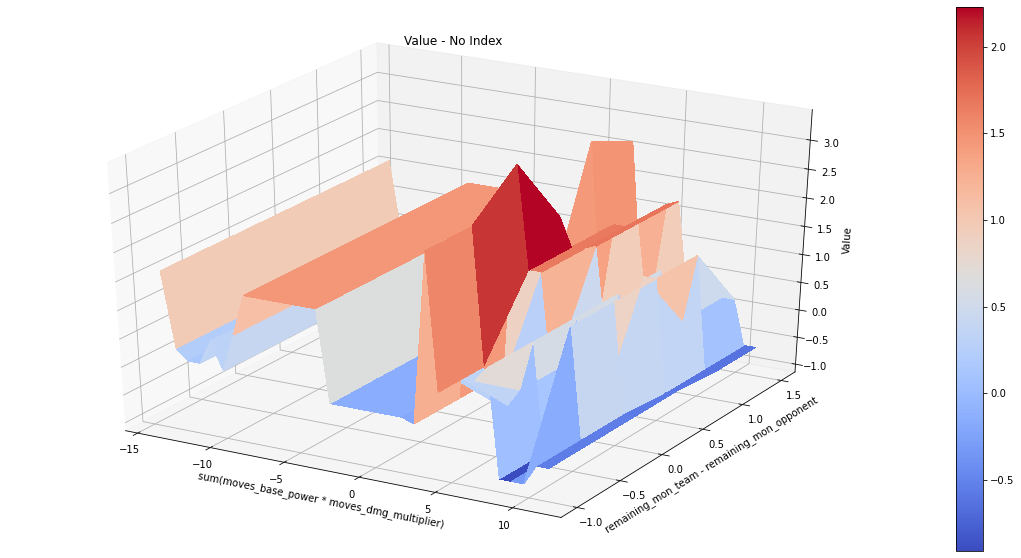

In [23]:
import pandas as pd
from scipy.interpolate import griddata
# create 1D-arrays from the 2D-arrays
for vvalue, filenameQ in zip(v_array, os.listdir(directoryQ)):
    filenameQ = re.sub(r"[,!?.><:'\[\]()@*~#]","_", filenameQ)
    x_values, y_values, z_values = vvalue 
    z_plot = np.array(z_values).reshape(len(z_values),1)
    x_plot = np.array(x_values)
    y_plot = np.array(y_values)
    xyz = {'x': x_plot, 'y': y_plot, 'z': np.array(z_values)}
    df = pd.DataFrame(xyz, index=range(len(xyz['x']))) 
    x1 = np.linspace(df['x'].min(), df['x'].max(), len(df['x'].unique()))
    y1 = np.linspace(df['y'].min(), df['y'].max(), len(df['y'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    z2 = griddata((df['x'], df['y']), df['z'], (x2, y2), method='nearest')

    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca(projection='3d')
    ax.set_xlabel('sum(moves_base_power * moves_dmg_multiplier)')
    ax.set_ylabel('remaining_mon_team - remaining_mon_opponent')
    ax.set_zlabel('Value')
    ax.set_title('Value - No Index')

    surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm,
        linewidth=0, antialiased=False)
    fig.colorbar(surf)
    filename = filenameQ+'_Det_noIndex.pdf'
    path_plot = output_folder+'/QLearning/'
    if not os.path.exists(path_plot):
        os.makedirs(path_plot)
    plt.savefig(path_plot+filename) 
    plt.show()

In [24]:
v_array = []
#for test in tests:
directoryQ = r'S:\poke_env\Q_Learning_table'

for filenameQ in os.listdir(directoryQ):
    Qjson_file = open(directoryQ+'/'+filenameQ,)
    Qjson = json.load(Qjson_file)

    for key in Qjson:
        Qjson[key] = np.array(Qjson[key])
        
    z_values = []
    x_values = []
    y_values = []
    for state, actions in Qjson.items(): 
        
        action_value = np.max(actions)
        z_values.append(action_value)
        state = re.sub(r"[,!?><:'\[\]()@*~#]","", state)
        key_float = [float(k) for k in state.split()]
        x_emb = (key_float[8]-key_float[9])*(key_float[1]*key_float[5]+key_float[2]*key_float[6]+key_float[3]*key_float[7]+key_float[4]*key_float[8])
        x_values.append(x_emb)
        y_emb = np.argmax(actions)
        y_values.append(y_emb)
        #V[x_emb,y_emb] = action_value
    v_array.append((x_values, y_values, z_values))

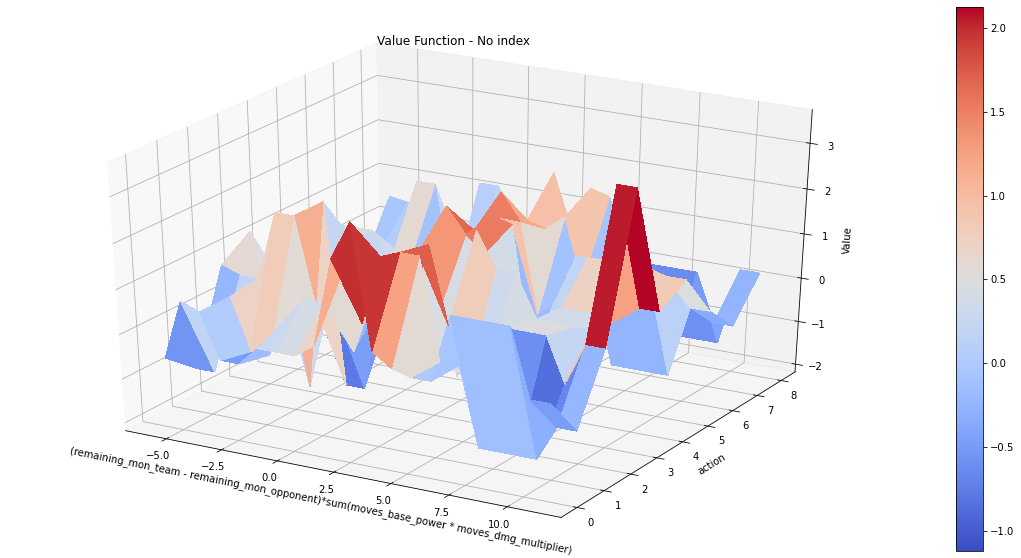

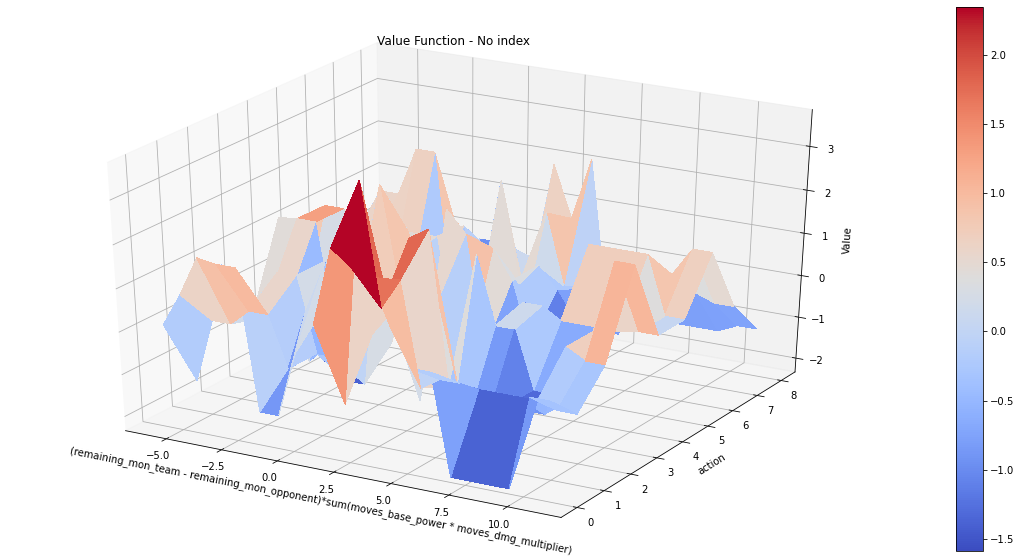

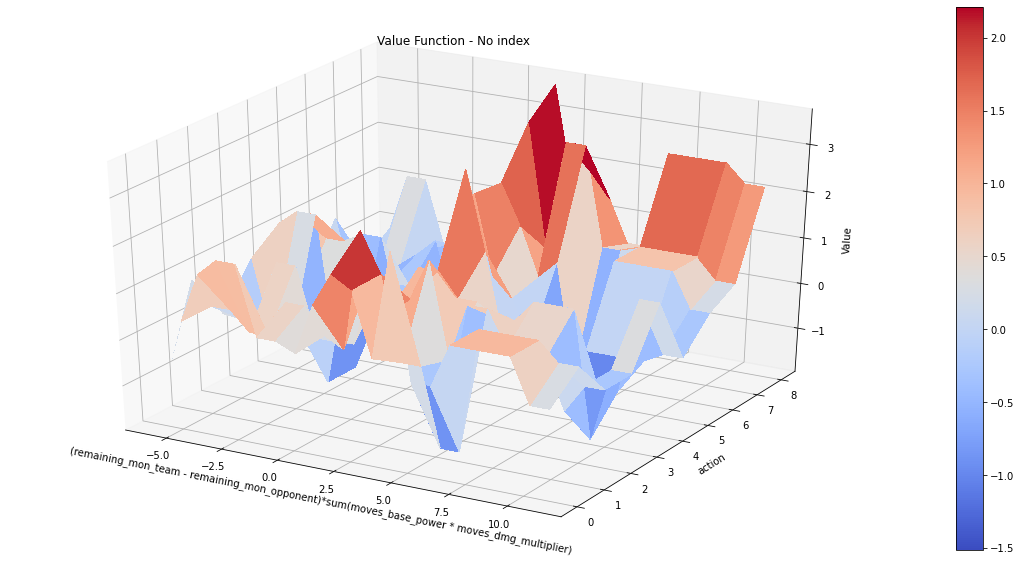

In [25]:
import pandas as pd
from scipy.interpolate import griddata
# create 1D-arrays from the 2D-arrays
for vvalue, filenameQ in zip(v_array, os.listdir(directoryQ)):
    filenameQ = re.sub(r"[,!?.><:'\[\]()@*~#]","_", filenameQ)
    x_values, y_values, z_values = vvalue 
    z_plot = np.array(z_values).reshape(len(z_values),1)
    x_plot = np.array(x_values)
    y_plot = np.array(y_values)
    xyz = {'x': x_plot, 'y': y_plot, 'z': np.array(z_values)}
    df = pd.DataFrame(xyz, index=range(len(xyz['x']))) 
    x1 = np.linspace(df['x'].min(), df['x'].max(), len(df['x'].unique()))
    y1 = np.linspace(df['y'].min(), df['y'].max(), len(df['y'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    z2 = griddata((df['x'], df['y']), df['z'], (x2, y2), method='nearest')

    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca(projection='3d')
    ax.set_xlabel('(remaining_mon_team - remaining_mon_opponent)*sum(moves_base_power * moves_dmg_multiplier)')
    ax.set_ylabel('action')
    ax.set_zlabel('Value')
    ax.set_title('Value Function - No index')

    surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm,
        linewidth=0, antialiased=False)
    fig.colorbar(surf)
    filename = filenameQ+'_Det_noIndex_action.pdf'
    path_plot = output_folder+'/QLearning/'
    if not os.path.exists(path_plot):
        os.makedirs(path_plot)
    plt.savefig(path_plot+filename)     
    plt.show()    